In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import pandas as pd
import os
import math

plt.style.use("mystyle.mplstyle")

g = 9.81
sampling_frequency = 100 # Hz

springs_k = {
    "pretensionata": 24.24969964,
    "non_pretensionata": 3.225655027,
}

In [14]:
dataframes = dict()

for root, dirs, files in os.walk("./data"):
    for file in files:
        if ".csv" in file:
            current_file_path = os.path.join(root, file).replace("\\", "/")
            dataframes[file] = pd.read_csv(current_file_path, sep=';', decimal=',')
    break  # stop at first recursion level: only ./data

sonar resolution: 0.020799999999999985


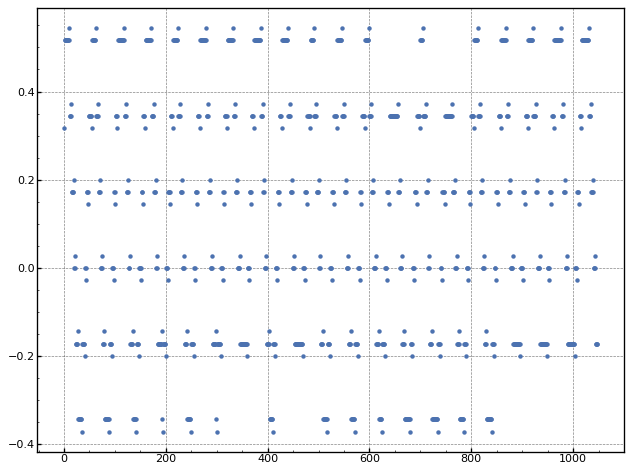

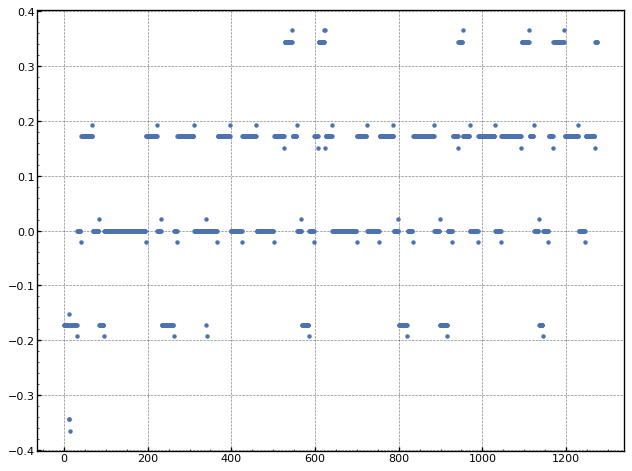

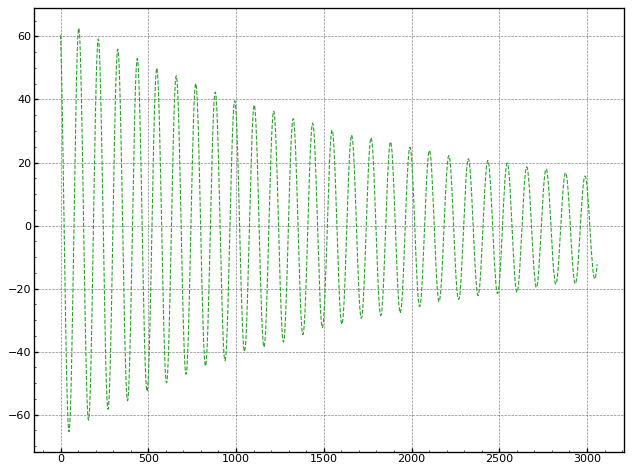

In [15]:
### sonar resolution ###

def calc_res(signal: list):
    diffs = []
    for i in range(len(signal) - 1):
        diffs.append(abs(signal[i] - signal[i+1]))
    return min([d for d in diffs if d > 0])

k_measurements = [(name, df) for (name,df) in dataframes.items() if "k statiche" in name]
sonar_resolution = 0

for name,df in k_measurements:
    signal = df.iloc[:,0]
    sonar_resolution = calc_res(signal)

    fig,ax = plt.subplots()
    ax.scatter(np.linspace(0,len(signal),len(signal)), signal)
print(f"sonar resolution: {sonar_resolution}")


test_df = pd.read_csv("data/Oscillazioni non_pretensionata_cd_3e1masse.csv", sep=';', decimal=',')

fig,ax=plt.subplots()
ax.plot(np.linspace(0, len(test_df.iloc[:,0]), len(test_df.iloc[:,0])), test_df.iloc[:,0], c='tab:green', ls='--')

del fig,ax,k_measurements, test_df

In [16]:
def take_one_every(data, step):
    return [data[j] for j in range(0,len(data),step)]


def estimate_gamma(peaks, period, freq):
    idx = 0
    for i in range(len(peaks)):
        if peaks[i] < peaks[0]:
            idx = i
            break
    return 1 / (idx * period / freq)

def worst_case_sampling(A0, omega, freq):
    return A0 * (1 - math.cos(omega / (2 * freq)))



def linear_damped_oscillator(t, amplitude, gamma, omega_zero, phase):
    return amplitude * np.exp(-gamma * t) * np.sin(omega_zero * t + phase)

def viscous_damped_oscillator(t, amplitude, alpha, omega_zero, phase):
    return (1 / (1 + amplitude * alpha * t)) * np.cos(omega_zero * t + phase)




def calculate_mean_difference(data: list, freq: float):
    acc_mean = 0
    for i in range(len(data) - 1):
        acc_mean += abs(data[i] - data[i + 1]) / freq
    mean = acc_mean / (len(data) - 1)

    acc_sigma = 0
    for i in range(len(data) - 1): # there are N-1 periods
        acc_sigma += (((data[i] - data[i + 1]) / freq) - mean) ** 2
    sigma = math.sqrt(acc_sigma / (len(data) - 2))

    return (mean, sigma, sigma / math.sqrt(len(data) - 1))




def calc_lin_reg(x: list, y: list, x_errs: list, y_errs: list, m_test: float):
    # y = Ax + B
    N = len(x)

    for i in range(N):
        y_errs[i] = math.sqrt(y_errs[i] ** 2 + m_test**2 * x_errs[i] ** 2)

    sum_x2 = 0
    sum_x = 0
    sum_y = 0
    sum_xy = 0
    sum_sigma_y2 = 0

    for i in range(N):
        sum_x += x[i] / y_errs[i] ** 2
        sum_x2 += x[i] ** 2 / y_errs[i] ** 2
        sum_y += y[i] / y_errs[i] ** 2
        sum_xy += x[i] * y[i] / y_errs[i] ** 2
        sum_sigma_y2 += 1 / (y_errs[i] ** 2)

    delta = sum_sigma_y2 * sum_x2 - sum_x**2
    A = (1 / delta) * (sum_sigma_y2 * sum_xy - sum_x * sum_y)
    B = (1 / delta) * (sum_x2 * sum_y - sum_x * sum_xy)
    sA = math.sqrt((1 / delta) * sum_x2)
    sB = math.sqrt((1 / delta) * sum_sigma_y2)

    sigma_y = []
    for i in range(len(y_errs)):
        sigma_y.append(math.sqrt(y_errs[i] ** 2 + (m_test**2) * (x_errs[i] ** 2)))

    return (A, B, sA, sB, sigma_y)



def calc_chi_sqr(observed, expected, sigma_y, deg_of_freedom: int):
    chi2i = np.divide(np.square(observed - expected), np.square(sigma_y))
    chi2 = np.sum(chi2i)
    chi2r = chi2 / deg_of_freedom
    return (chi2i, chi2, chi2r)

def pearson_formula(observed, expected, deg_of_freedom: int):
    partial_sum = 0
    for i in range(len(observed)):
        partial_sum += ((observed[i] - expected[i]) ** 2) / expected[i]
    return partial_sum / deg_of_freedom

In [17]:
### k estimate ###

"""
dfs = [dataframes["Misure k statiche non_pretensionata.csv"], dataframes["Misure k statiche pretensionata.csv"]]

masses = g * np.array([])
positions = []
positions_errs = []

for df in dfs:
    for i in range(3):
        # X = np.linspace(0, len(df.iloc[:,i]), len(df.iloc[:,i]))
        signal = df.iloc[:,i]
        mean_pos = np.mean(signal)
        sigma_mean_pos = np.std(signal) / np.sqrt(len(signal))
        positions.append(mean_pos)
        positions_errs.append(sigma_mean_pos)

k_estimates = {
    "non_pretensionata": calc_lin_reg(),
    "pretensionata": 0
}
"""

'\ndfs = [dataframes["Misure k statiche non_pretensionata.csv"], dataframes["Misure k statiche pretensionata.csv"]]\n\nmasses = g * np.array([])\npositions = []\npositions_errs = []\n\nfor df in dfs:\n    for i in range(3):\n        # X = np.linspace(0, len(df.iloc[:,i]), len(df.iloc[:,i]))\n        signal = df.iloc[:,i]\n        mean_pos = np.mean(signal)\n        sigma_mean_pos = np.std(signal) / np.sqrt(len(signal))\n        positions.append(mean_pos)\n        positions_errs.append(sigma_mean_pos)\n\nk_estimates = {\n    "non_pretensionata": calc_lin_reg(),\n    "pretensionata": 0\n}\n'

~~~~~~~~~~~~~
non_pretensionata, Rete:
	[0]	period: 1.0789473684210527 +- 0.5086257805815655
		omega_0	= 0.18912713518842805
		gamma	= 92.6829268292683
		sampling error:	2.5776325530941704
		sonar resolution:	0.020799999999999985

		[lineare]:
		 y = 0.050275130828582024 x +- 0.3988190137098883
		chi2r = 0.0014879478397484365
		[quadratica]:
		 y = 0.03746642587655109 x +- 4.109006019729083
		chi2r = 7.34139821465372e-05

	[1]	period: 0.8283333333333331 +- 0.3454434243407881
		omega_0	= 0.2524090928005217
		gamma	= 120.72434607645877
		sampling error:	5.66129390973484
		sonar resolution:	0.020799999999999985

		[lineare]:
		 y = 0.07908053696158236 x +- 0.36597089660720644
		chi2r = 0.0006868713839330914
		[quadratica]:
		 y = 0.010280787899809074 x +- 3.488918803855502
		chi2r = 0.004051973303095546

~~~~~~~~~~~~~
pretensionata, Rete:
	[0]: [math error] len(peaks) = 42, len(rising edges) = 0
	[0]	period: 0.47682926829268296 +- 0.15079087559202126
		omega_0	= 0.4322142754216751
		gamma

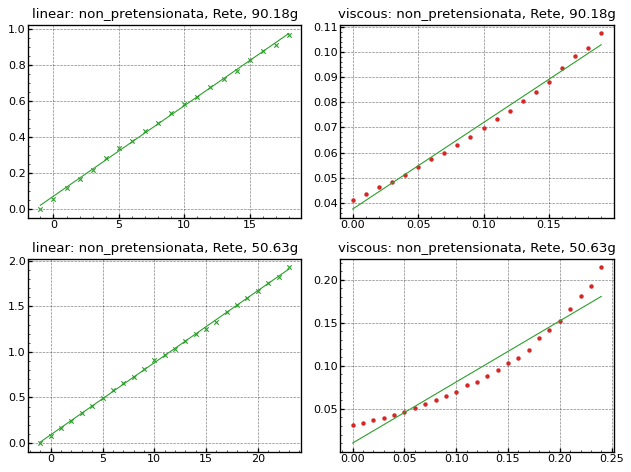

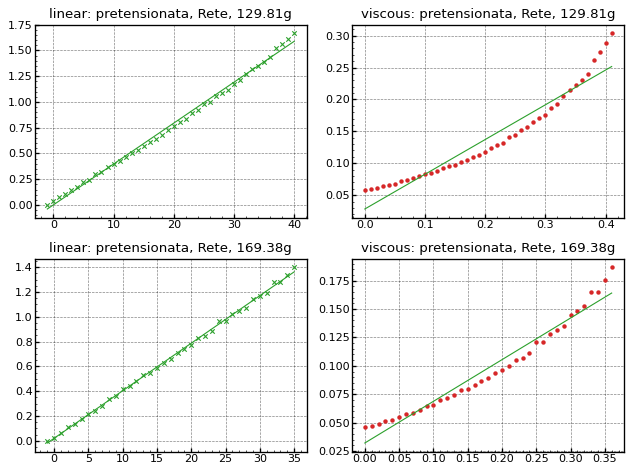

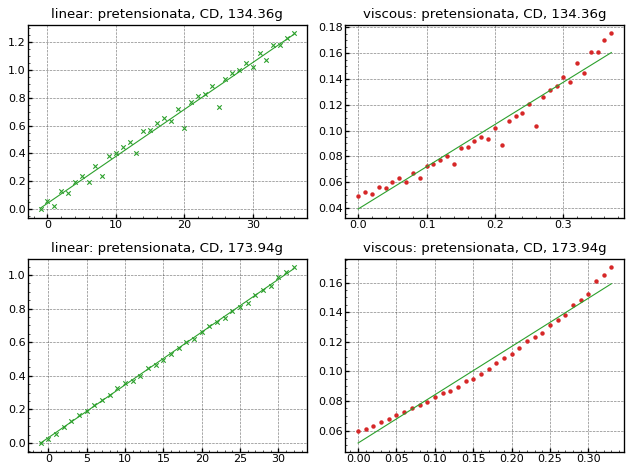

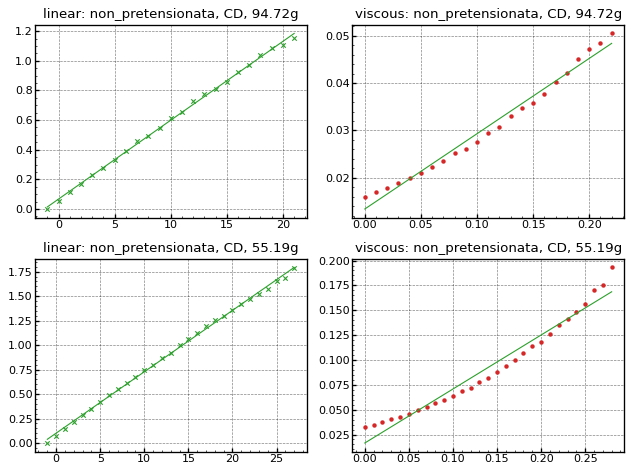

In [18]:
masses = {
    # 3 masse, 1 massa
    "non_pretensionata": {
        "CD": [94.72, 55.19],
        "Rete": [90.18, 50.63]
    },
    # 5 masse, 7 masse
    "pretensionata": {
        "CD": [134.36, 173.94],
        "Rete": [129.81, 169.38]
    }
}

results = dict()


peak_periods = []
peak_periods_errs = []
rise_periods = []
rise_periods_errs = []


for name,df in filter(lambda e: "Oscillazioni" in e[0], dataframes.items()):
    spring = "non_pretensionata" if "non_pretensionata" in name else "pretensionata"
    damper = "CD" if "_cd_" in name else "Rete"

    print(f"~~~~~~~~~~~~~\n{spring}, {damper}:")

    results[spring] = { damper: [] }

    df.dropna(inplace=True)
    fig,ax = plt.subplots(2,2)

    for i in range(2):
        X = np.linspace(0, len(df.iloc[:,i]), len(df.iloc[:,i]))
        Y = df.iloc[:,i]
        

        # ~ periods from peaks and from rising edges ~

        peaks_pos, _ = find_peaks([y if y >= 0 else 0 for y in Y], width=10)
        # peaks = take_one_every([Y[j] for j in peaks_pos], 6) ############## if you take less than the total, remember that in X = (n-1) from the slides the n is {0, step, 2*step, ..., n*step}, for n natural
        peaks = [Y[j] for j in peaks_pos]
        rising_edges_pos, _ = find_peaks([max(Y) - abs(y) for y in Y], width = 10)
        rising_edges = [Y[j] for j in rising_edges_pos]

        peak_mean_period, peak_sigma_period, peak_sigma_mean_period = calculate_mean_difference(peaks_pos, sampling_frequency)
        try: # some of these lists have length of zero...
            rise_mean_period, rise_sigma_period, rise_sigma_mean_period = calculate_mean_difference(rising_edges_pos, sampling_frequency)
        except:
            print(f"\t[{i}]: [math error] len(peaks) = {len(peaks)}, len(rising edges) = {len(rising_edges)}")

        peak_periods.append(peak_mean_period)
        peak_periods_errs.append(peak_sigma_mean_period)
        rise_periods.append(rise_mean_period)
        rise_periods_errs.append(rise_sigma_mean_period)

        print(f"\t[{i}]\tperiod: {peak_mean_period} +- {peak_sigma_mean_period}")



        # ~ errors ~
        omega_0 = math.sqrt(springs_k[spring] / masses[spring][damper][i])
        gamma = estimate_gamma(peaks, peak_mean_period, sampling_frequency)
        sampling_error = worst_case_sampling(peaks[0], math.sqrt(omega_0 ** 2 + gamma ** 2), sampling_frequency)
        print(f"\t\tomega_0\t= {omega_0}\n\t\tgamma\t= {gamma}")
        print(f"\t\tsampling error:\t{sampling_error}\n\t\tsonar resolution:\t{sonar_resolution}")


        # ~ linear regressions ~

        # linearised points
        # TODO: calculate errors for these things with error propagation                             < --------------

        ###### TODO: check indices when doing peaks[n] for linearised points

        linear_points_x = [n-1 for n in range(len(peaks))]
        linear_points_x_errs = [0 for _ in range(len(linear_points_x))]
        linear_points_y = [math.log(peaks[0] / peaks[n], math.e) for n in range(len(peaks))]
        linear_points_y_errs = [sonar_resolution for _ in range(len(linear_points_y))] # because sampling error is too small

        viscous_points_x = [n/sampling_frequency for n in range(len(peaks))]
        viscous_points_x_errs = [n * peak_sigma_period for n in range(len(viscous_points_x))]
        viscous_points_y = [1 / peaks[n] for n in range(len(peaks))]
        viscous_points_y_errs = [sonar_resolution / (peaks[n] ** 2) for n in range(len(viscous_points_y))]

        # regression parameters
        linear_m_test = (linear_points_y[-1] - linear_points_y[0]) / (linear_points_x[-1] - linear_points_x[0])
        linear_A, linear_B, linear_sA, linear_sB, linear_sigma_y = calc_lin_reg(linear_points_x, linear_points_y, [1 for _ in range(len(linear_points_x))], [1 for _ in range(len(linear_points_x))], linear_m_test)
        linear_lin_reg_x = np.linspace(linear_points_x[0],linear_points_x[-1], len(linear_points_x))
        # _, _, linear_chi2r = calc_chi_sqr(linear_points_y, linear_lin_reg_x * linear_A + linear_B, linear_sigma_y, len(linear_points_y) - 2)
        linear_chi2r = pearson_formula(linear_points_y, linear_lin_reg_x * linear_A + linear_B, len(linear_points_y) - 2)

        viscous_m_test = (viscous_points_y[-1] - viscous_points_y[0]) / (viscous_points_x[-1] - viscous_points_x[0])
        viscous_A, viscous_B, viscous_sA, viscous_sB, viscous_sigma_y = calc_lin_reg(viscous_points_x, viscous_points_y, [1 for _ in range(len(viscous_points_x))], [1 for _ in range(len(viscous_points_x))], viscous_m_test)
        viscous_lin_reg_x = np.linspace(viscous_points_x[0],viscous_points_x[-1], len(viscous_points_x))
        # _, _, viscous_chi2r = calc_chi_sqr(viscous_points_y, viscous_lin_reg_x * viscous_A + viscous_B, viscous_sigma_y, len(viscous_points_y) - 2)
        viscous_chi2r = pearson_formula(viscous_points_y, viscous_lin_reg_x * viscous_A + viscous_B, len(viscous_points_y) - 2)

        print(f"\n\t\t[lineare]:\n\t\t y = {linear_A} x +- {linear_sA}\n\t\tchi2r = {linear_chi2r}")
        print(f"\t\t[quadratica]:\n\t\t y = {viscous_B} x +- {viscous_sB}\n\t\tchi2r = {viscous_chi2r}\n")

        # plotting
        ax[i,0].set_title(f"linear: {spring}, {damper}, {masses[spring][damper][i]}g")
        ax[i,0].scatter(linear_points_x, linear_points_y, marker='x', c='tab:green')
        ax[i,0].plot(linear_lin_reg_x, linear_lin_reg_x * linear_A + linear_B, marker='x', c='tab:green')
        ax[i,1].set_title(f"viscous: {spring}, {damper}, {masses[spring][damper][i]}g")
        ax[i,1].scatter(viscous_points_x, viscous_points_y, marker='o', c='tab:red')
        ax[i,1].plot(viscous_lin_reg_x, viscous_lin_reg_x * viscous_A + viscous_B, marker='x', c='tab:green')

        # linear_fit_args, _ = curve_fit(linear_damped_oscillator, X, Y)
        # viscous_fit_args, _ = curve_fit(viscous_damped_oscillator, X, Y)

        # ax[i].scatter(X, Y, s=1.5, c='tab:red')
        # ax[i].scatter(peaks_pos, peaks, marker='x', c='tab:green')
        # ax[i].plot(X, linear_damped_oscillator(X, *linear_fit_args), linewidth=0.5, c='tab:green')
        # ax[i].plot(X, viscous_damped_oscillator(X, *viscous_fit_args), linewidth=0.5, c='tab:blue')